This Ipython notebook first loads an individual adcp in and then calculates and plots all kinds of things
- heat
- surfer plots

In [1]:
# Import required libraries
import os
import sys
import warnings
from datetime import datetime, timedelta

import cmocean as cmo
import gsw
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.transforms import blended_transform_factory
from scipy.interpolate import griddata, interp1d, interp2d

# Ignore warnings
warnings.filterwarnings("ignore")

# Set the path for the src directory
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import custom modules
from paths import *
from velocity_preprocessing_functions import open_and_proces_mat_adcp

# from functions import *


# 

Importing both velocity files

In [2]:


ds_velo_300, _, df_cons300, _, _, my_prediction_along_300, _, _, _, ds_velo_no_outlier_removal_300 = open_and_proces_mat_adcp(f300)
ds_velo_75, _, df_cons75, _, _, pred_75, _, _, _, ds_velo_no_outlier_removal_75 = open_and_proces_mat_adcp(f75)
print("Total amplitude tide : ", df_cons75['Velocity amplitude [mm/s]'].sum().round(2))

Total amplitude tide :  23.68


In [3]:
df_velo_both = xr.merge([ds_velo_300, ds_velo_75], join='outer')
df_velo_outliers = xr.merge([ds_velo_no_outlier_removal_300, ds_velo_no_outlier_removal_75], join='outer')


## plotting functions

In [4]:

def format_surfer(variable, levels_f, fig, ax2, contourf, contourl):
    if  contourl: 
        ax2.clabel(contourl, fmt = '%2.1f', fontsize=8)
    ax2.invert_yaxis()
    ax2.set_ylabel("Pressure [dbar]")
    plt.ylim([540,0])
    ax2.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))

def datetime_to_decimal_days(date, start_date= '2017-01-01'):
    days = df_ctd_moor.date - pd.to_datetime(start_date)
    return days / timedelta(days=1)

def decimal_day_to_datetime(days):
    return pd.to_datetime(days, unit='D', origin='2017-01-01')


def add_arrows_for_sampling_loc(mean_pres, ax,  datelim, zlim, arrowhead, arrowtail,color_mooring='b', color_ctd='r'):
    '''
    Arrows for CTD on top
    Arrows for mooring on the side
    mean_pres = list of mean pressure values of mooring
    ax = axes object
    takes datelim as list of 2 datetime objects
    zlim = list of 2 depth values
    '''
    selected_dates = df_monthly[(df_monthly.date >= datelim[0]) & (df_monthly.date <= datelim[1])].datedate.unique()
    for date in selected_dates:
        ax.annotate('', xy=(date, arrowhead), xycoords='data', xytext=(date, arrowtail), 
            arrowprops=dict(arrowstyle="->", color='black'), annotation_clip=False)
    for i,depth in enumerate(mean_pres):
        if depth > zlim[0]: continue  
        if depth < zlim[1]: continue
        ax.annotate('', xy=(datetime(2018, 5,29), depth), xycoords='data', xytext=(datetime(2018, 5,20), depth), 
            arrowprops=dict(arrowstyle="->", color=color_mooring[i]), annotation_clip=False)

def fmt_label(x):
    s = f"{x:.1f}"
    if s.endswith(".0"):
        s = f"{x:.0f}"
    elif (float(s)*10).is_integer():
        s = f"{x:.1f}"
    elif (float(s)*100).is_integer():
       s = f"{x:.2f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

def format_colorbar_tick(value, pos):
    if value.is_integer():
        return f'{int(value)}'
    elif (value*10).is_integer():
        return f'{value:.1f}'
    elif (value*100).is_integer():
        return f'{value:.2f}'
    else:
        return value

def add_text_to_ax(ax, xloc, text, fontsize=10):
    ax.text(xloc, 1.05, text, transform=blended_transform_factory(ax.transData,ax.transAxes), fontsize=fontsize, fontweight='bold', ha='center', font="Palatino")

def format_colorbar_tick(value, pos):
    if value.is_integer():
        return f'{int(value)}'  # Format integers without decimal places
    elif (value*10).is_integer():
        return f'{value:.1f}'
    elif (value*100).is_integer():
        return f'{value:.2f}'
    elif (value*1000).is_integer():
        return f'{value:.3f}'
    else:
        return f'{value}'  #b Format floating-point numbers with one decimal place

def add_arrows(date1, y1, date2, y2, ax):
    ax.annotate('', xy=(date1, y1), xytext=(0, y2), textcoords='offset points',
                arrowprops=dict(edgecolor='red',arrowstyle="->"), clip_on=False)
    ax.annotate('', xy=(date2, y1), xytext=(0, y2), textcoords='offset points',
                arrowprops=dict(edgecolor='red', arrowstyle="->",), clip_on=False)


def get_colormap_and_properties(variable):
    contour_colors = 'black'
    bounds = None
    norm = None
    levels_l = None
    ticks = None
    ticklabels = None
    short_label = None
    
    if variable == 'Potential temperature [°C]':
        cmap = mpl.colors.ListedColormap(cmo.cm.thermal(np.linspace(0, 1, 15)))
        bounds_cbar_TS = [-1.8, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.5, 10]
        norm =mpl.colors.BoundaryNorm(bounds_cbar_TS, cmap.N)
        levels_l = [-1.8, 0, 1, 2, 3, 3.5, 10]
        contour_colors = ['white' if x <= 0 else 'black' for x in levels_l]
        ticks = [-1.8, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 10]
        ticklabels = ["-1.8", "0", "0.5", "1", "1.5", "2", "2.5", "3", "  3.5", "10"]
        short_label = 'Temperature [°C]'
        var = 'temp'
        levels_f =[-1.8, 0, 1, 2, 3,4, 10] 


    elif variable == 'Salinity [PSU]':
        cmap = mpl.colors.ListedColormap(cmo.cm.haline(np.linspace(0, 1, 6)))
        bounds_cbar_TS = [7.5, 30.5, 32.8, 33.2, 33.4, 33.5, 33.7]
        norm = mpl.colors.BoundaryNorm(bounds_cbar_TS, cmap.N)
        levels_l = np.sort(np.concatenate([np.arange(30, 33, 1), np.arange(33, 33.55, 0.1), [33.45, 33.55], np.arange(33.6, 35.1, 0.4)]))
        levels_f = np.concatenate(([10,15,20,25,30,31],np.arange(32,33.5,.2),np.arange(33.5,33.6,0.05)))
        contour_colors = ['white' if x <= 33 else 'black' for x in levels_l]
        var = 'sal'
        short_label = 'Salinity [PSU]'

    return var, cmap, bounds_cbar_TS, norm, levels_f, levels_l, contour_colors, ticks, ticklabels, short_label



### importing monthly CTD profiles and mooring timeseries

In [3]:
df_monthly = pd.read_csv(file_monthly_CTD, index_col=0, parse_dates=["date"])
df_monthly["datedate"] = df_monthly.date.copy()
df_monthly['datetime'] = pd.to_timedelta(df_monthly.time-1, unit='D') + pd.to_datetime(pd.to_datetime(df_monthly.datedate).dt.year, format='%Y')
df_monthly.date = df_monthly.datetime.copy()

df_gf10 = df_monthly[(df_monthly['St.']=="GF10")]#&(df_monthly['Type']=='CTD')]
df_mooring = pd.read_csv(file_mooring_microcat, index_col=0, parse_dates=True)


df_moor_daily = pd.DataFrame()
df_mooring.date = pd.to_datetime(df_mooring.date)
for d in df_mooring.depth.unique():
    df= df_mooring[df_mooring.depth==d].set_index('date')
    means = df.groupby(df.index.floor('D')).mean()
    df_moor_daily = pd.concat([df_moor_daily, means])
df_moor_daily = df_moor_daily.reset_index()

mean_pres = [  538.8,331.2,155.8,59.6, 5] # mean pressure [dbar] of mooring instruments



Gridding mooring data (time series) and ctd profiles (depth profile) on a grid

In [6]:
gridded_temp_sal = {}

for variable, var  in zip(['Potential temperature [°C]', 'Salinity [PSU]', 'sigma-dens'], ['temp', 'sal', 'sigma-dens']):
    df_ctd_moor = pd.concat([
        df_monthly.set_index(['Pressure [dbar]', 'date'])[var], 
        df_moor_daily[df_moor_daily.depth > 5].set_index(['Pressure [dbar]', 'date'])[var]
    ])
    df_ctd_moor = df_ctd_moor.reset_index().dropna()
    df_ctd_moor['days_decimal'] = datetime_to_decimal_days(df_ctd_moor.date)
    df_ctd_moor['depth'] = gsw.z_from_p(df_ctd_moor['Pressure [dbar]'], 64) * -1

    if var == 'sigma-dens':
        xi = np.arange(df_ctd_moor['days_decimal'].min(), df_ctd_moor['days_decimal'].max(), 3)
        yi = np.arange(df_ctd_moor['depth'].min(), df_ctd_moor['depth'].max() + 1, 6)
    else:
        xi = np.arange(df_ctd_moor['days_decimal'].min(), df_ctd_moor['days_decimal'].max(), 3)
        yi = np.arange(df_ctd_moor['depth'].min(), df_ctd_moor['depth'].max() + 1, 3)
    xi_date = decimal_day_to_datetime(xi)
    valid_indices = ~np.isnan(df_ctd_moor[var].to_numpy())
    points = (df_ctd_moor['days_decimal'].to_numpy()[valid_indices], df_ctd_moor['depth'].to_numpy()[valid_indices])
    values = df_ctd_moor[var].to_numpy()[valid_indices]
    zi = griddata(points, values, (xi[None, :], yi[:, None]), method='linear')

    gridded_temp_sal[variable] = {
        'xi': xi,
        'yi': yi,
        'xi_date': xi_date,
        'zi': zi
    }

z_dens = gridded_temp_sal['sigma-dens']['zi']
yi_dens = gridded_temp_sal['sigma-dens']['yi']
xi_dens = gridded_temp_sal['sigma-dens']['xi']
xi_date_dens = gridded_temp_sal['sigma-dens']['xi_date']



Resample velocity data for plotting (otherwise it is way to slow and not in control)

In [7]:
resample_time = '25h'
ds_300_resampled = (ds_velo_300 / 1000).resample(time=resample_time).mean()
ds_75_resampled = (ds_velo_75 / 1000).sel(z=slice(550 + 5, None)).resample(time=resample_time).mean()


In [10]:
plt.rcParams.update({'font.size': 12})
pd.options.plotting.backend = "matplotlib"

fontsize_ticks = 12
fontsize_alpha = 12
fontsize_clabel = 8
fontsize_cbar = 10
fontsize_cbar_ticks = 8

max_cbar_velo = 0.16  #m/s
levels_velo = np.arange(-max_cbar_velo, max_cbar_velo*1.001, 0.04).round(3)
levels_sigmadens_new = np.sort(np.concatenate([np.arange(24,26.6,0.5), np.arange(26.6,27,0.1)]))

cmap_velo = 'PRGn'

cm = 1/2.54  # centimeters in inches
mm = cm/10.  # millimeters in inches

color_mooring_depth =['cyan','royalblue',  'red','black', 'green'][::-1]
cmap_velo = 'PRGn'


# Figure 2

Adding phases
Adding inflow boxes
Format axes
Saving figure
Showing figure


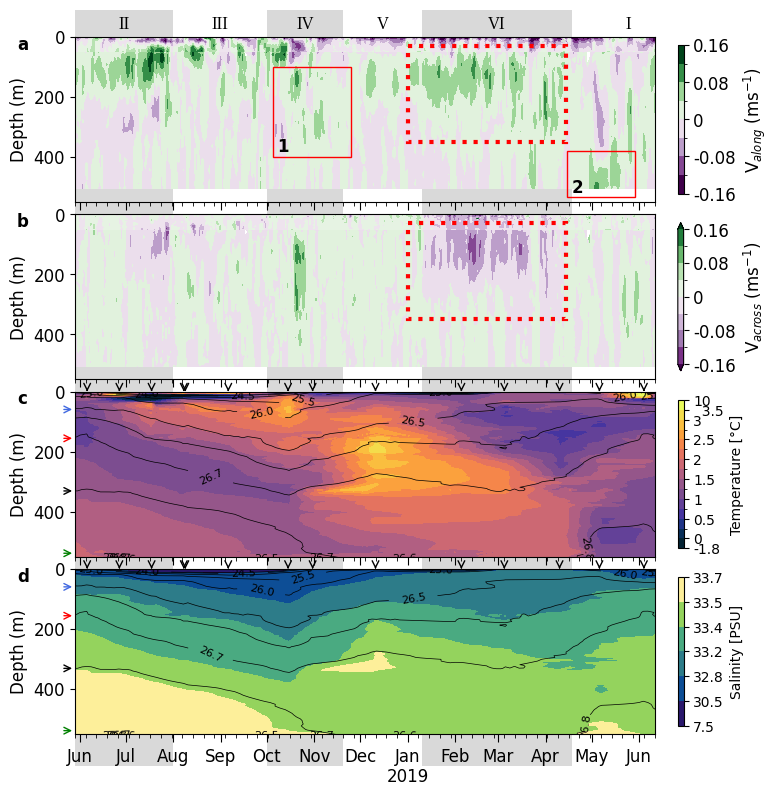

In [ ]:

zlim = [550, 0]
datelim = [datetime(2018, 5,29), datetime(2019, 6, 11)]

fig, ax = plt.subplots(4, figsize=(190*mm, 230*mm), sharex=False, sharey=True)

# ==================================================================================================
# Velocity
# ==================================================================================================


contour_velo = ds_75_resampled.Along_res.plot.contourf(y='z', robust=True, ax=ax[0], cmap=cmap_velo, levels=levels_velo, extend=None, add_colorbar=False)
ds_300_resampled.Along_res.plot.contourf(y='z', robust=True, ax=ax[0], cmap=cmap_velo, levels=levels_velo,  add_colorbar=False, extend=None)
ds_75_resampled.Across_res.plot.contourf(y='z', robust=True, ax=ax[1], cmap=cmap_velo, levels=levels_velo ,extend=None, add_colorbar=False)
cvelo_cross = ds_300_resampled.Across_res.plot.contourf(y='z', robust=True, ax=ax[1], cmap=cmap_velo, levels=levels_velo,  add_colorbar=False,extend=None)


cax0 = ax[0].inset_axes( [1.04, 0.05, 0.01, 0.9] )    
cax1 = ax[1].inset_axes( [1.04, 0.05, 0.01, 0.9] )
cbar0 = fig.colorbar(contour_velo, orientation='vertical', label=r'V$_{along}$ (ms$^{-1}$)', ticks=levels_velo[::2], ax =ax[0], cax=cax0)
cbar1 = fig.colorbar(cvelo_cross, orientation='vertical', label=r'V$_{across}$ (ms$^{-1}$)', ticks=levels_velo[::2], ax =ax[1], cax=cax1)
for cbar in [cbar0, cbar1]: cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(format_colorbar_tick))



#==================================================================================================
# Temperature and salinity
#==================================================================================================
for variable, i in zip(['Potential temperature [°C]', 'Salinity [PSU]'], [2,3]):
    var, cmap, bounds_cbar_TS, norm, levels_f, levels_l, contourcolors, ticks, ticklabels, short_label = get_colormap_and_properties(variable)
    xi, yi, xi_date, zi = gridded_temp_sal[variable]['xi'], gridded_temp_sal[variable]['yi'], gridded_temp_sal[variable]['xi_date'], gridded_temp_sal[variable]['zi']


    contourf = ax[i].contourf(xi_date, yi, zi, levels=bounds_cbar_TS, norm=norm, cmap=cmap, extend=None)
    contourl = ax[i].contour(xi_date_dens, yi_dens, z_dens, levels=levels_sigmadens_new, linewidths= 0.5, colors ='black')
    ax[i].clabel(contourl, inline=True, fontsize=fontsize_clabel, rightside_up=True, inline_spacing=1, )


    caxTS = ax[i].inset_axes( [1.04, 0.05, 0.01, 0.9] )
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
        cax=caxTS,
        ax = ax[i],
        extend=None, 
        ticks=bounds_cbar_TS,
        spacing='uniform',
        orientation='vertical',
    )

    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(format_colorbar_tick))
    cbar.set_label(     label=short_label,size=fontsize_cbar)
    cbar.ax.tick_params(labelsize=fontsize_cbar)
    if var == 'temp':
        cbar.set_ticks(ticks)
        cbar.set_ticklabels(ticklabels)


    add_arrows_for_sampling_loc(mean_pres, ax[i], arrowhead=0, arrowtail=-5, zlim=[zlim[0], 6], datelim=datelim, color_mooring=color_mooring_depth)
    format_surfer(short_label, levels_f, fig, ax[i], contourf, None)



# ==================================================================================================
# Adding phases
# ==================================================================================================

yloc = [0.075, 0.91]
xlocs = ['May 29, 2018', 'August 1, 2018', 'October 1, 2018', 'November 20, 2018', 'January 10, 2019', 'April 18, 2019', 'July 1, 2019']
phases = ['II', 'III', 'IV', 'V', 'VI', 'I']
xlocs = pd.to_datetime(xlocs)
print(f"Adding phases")
for i in range(len(xlocs)-1):
    xloc_text = xlocs[i] + (xlocs[i+1]-xlocs[i])/2
    add_text_to_ax(ax[0], xloc_text, f'{phases[i]}', fontsize=fontsize_alpha)
    if i%2 ==0:
        width =  xlocs[i+1]-xlocs[i]
        height = yloc[1]-yloc[0]
        rectangle = mpatches.Rectangle((xlocs[i], yloc[0]), width, height, linewidth=0, edgecolor=None, facecolor='black', clip_on=False, alpha=0.15,  transform=blended_transform_factory(ax[0].transData,fig.transFigure), zorder=0)
        ax[0].add_patch(rectangle)

# ======= Adding inflow boxes ==========
print("Adding inflow boxes")
start =['October 5, 2018', 'April 15, 19']
end =[ 'Nov 25, 18',  'May 29, 19']
bottom = [400, 535]
top = [100, 380]
text_rectangles = ["1", "2"]

start = [pd.to_datetime(x) for x in start]
end = [pd.to_datetime(x) for x in end]


for i in range(len(start)):
    rect = mpatches.Rectangle((start[i], top[i]), end[i]-start[i], bottom[i]-top[i], linewidth=1, edgecolor='red', facecolor='none', alpha=1, clip_on=False)
    ax[0].add_patch(rect)
    ax[0].text((start[i]+pd.Timedelta(days=3)), bottom[i]-3,   text_rectangles[i], fontsize=fontsize_alpha, fontweight='bold', va='bottom')

start_win = 'Jan 1, 2019'
end_win = 'April 14, 2019'
top_win = 30
bottom_win = 350

for i in range(2):
    rect = mpatches.Rectangle((pd.to_datetime(start_win), top_win), pd.to_datetime(end_win)-pd.to_datetime(start_win), bottom_win-top_win, linewidth=3, edgecolor='red', facecolor='none', alpha=1, clip_on=False, linestyle = ":")
    ax[i].add_patch(rect)

print("Format axes")
for i in range(len(ax)):
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[i].xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax[i].xaxis.set_tick_params(which='minor', length=2, labelsize=fontsize_ticks)
    ax[i].set_ylim(zlim)
    ax[i].set_xlim(datelim)
    ax[i].set_xticklabels([])


for i in range(4):
    ax[i].set_ylabel('Depth (m)')
    ax[i].tick_params(axis='x', length=3, which='minor')
    ax[i].tick_params(axis='x', length=6, which='major')
    ax[i].patch.set_facecolor('none')

# Use mdates to generate dates at monthly intervals
dates = pd.date_range(start=datelim[0], end=datelim[1], freq='MS').to_pydatetime().tolist()
ax[-1].set_xticklabels([date.strftime('%b\n%Y') if date.month == 1 else date.strftime('%b') for i, date in enumerate(dates)])


fig.subplots_adjust(hspace=0.075)

# add a), b), c) etc. to subplots
alphabet = ['a', 'b', 'c', 'd', 'e', 'f']
for i in range(len(ax)):
    ax[i].text(-0.10, 0.9, alphabet[i], transform=ax[i].transAxes, fontsize=fontsize_alpha, fontweight='bold', va='bottom')
print("Saving figure")
fig.savefig(f"{figpath}/Figure2_TS_timeseries_less_colors_phase_{zlim[0]}_{cmap_velo}_box.jpg", dpi=300, bbox_inches='tight')
fig.savefig(f"{figpath}/Figure2_TS_timeseries_less_colors_phase_draft_{zlim[0]}_{cmap_velo}_box.jpg", dpi=150, bbox_inches='tight')
print("Showing figure")
fig.show()


# Figure 3

importing wind data first

In [93]:
ds_niaqornaa = xr.open_dataset(file_processed_niaqornaa_weather_station)

Adding wind
Adding phases
Format axes
Saving figure
Showing figure


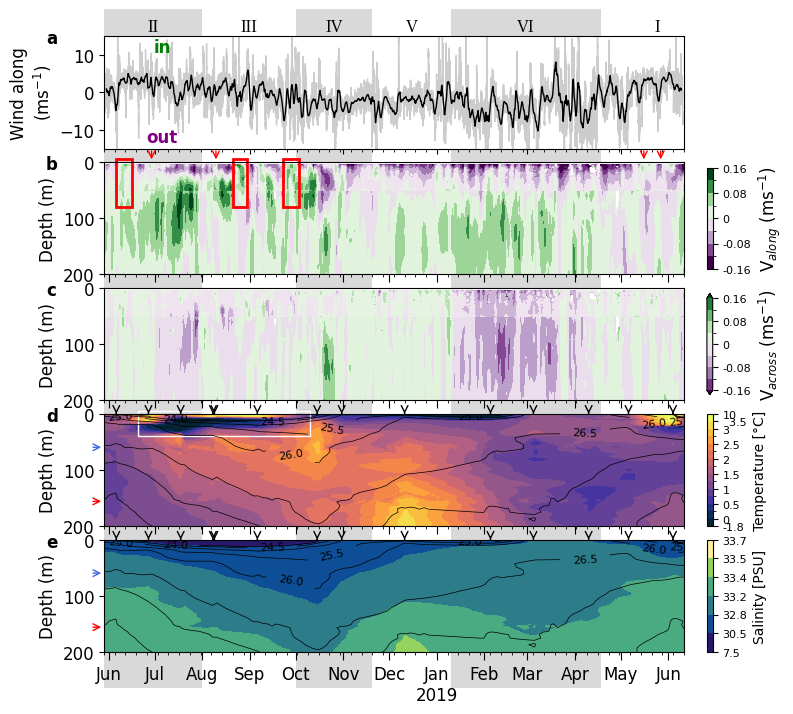

In [ ]:

# plot specific settings
zlim = [200, 0]
datelim = [datetime(2018, 5,29), datetime(2019, 6, 11)]


fig, ax = plt.subplots(5,1, figsize=(190*mm, 230*mm), sharex=False, sharey=False)
axALONG = ax[1]
axACROSS = ax[2]
axT = ax[3]
axS = ax[4]
axU = ax[0]

TSplots = [3,4]
VELOplots = [1,2]
HYDROplots = [1,2,3,4]

#==================================================================================================
# Wind
#==================================================================================================
white_background_rectangle = mpatches.Rectangle((0,0), 1, 1, linewidth=0, edgecolor=None, facecolor='white', clip_on=True, alpha=1, transform=ax[0].transAxes, zorder=1)
axU.add_patch(white_background_rectangle)

print("Adding wind")
ds_nia_select = ds_niaqornaa.sel(time=slice(datelim[0], datelim[1])).dropna(dim='time')
assert ds_nia_select['V_200cm_rotated'].size > 0
axU.plot(ds_nia_select['V_200cm_rotated'].to_dataframe(), color='black', linewidth=1, label="", alpha=0.2)

wind_rolling = ds_nia_select['V_200cm_rotated'].rolling(time=6*48,center=True).mean().to_dataframe()
assert not wind_rolling.empty
# axU.plot(ds_nia_select['V_200cm_rotated'].to_dataframe(), color='black', linewidth=1, label="", alpha=0.2)

wind_rolling.plot(ax=axU, color='black', linewidth=1, label="")
axU.fill_between( wind_rolling['V_200cm_rotated'].index, np.repeat(0, len(wind_rolling)), wind_rolling['V_200cm_rotated'], where=wind_rolling['V_200cm_rotated']>=0, color='green', interpolate=True, alpha=0.5)
axU.fill_between( wind_rolling['V_200cm_rotated'].index, np.repeat(0, len(wind_rolling)), wind_rolling['V_200cm_rotated'], where=wind_rolling['V_200cm_rotated']<0, color='purple', interpolate=True, alpha=0.5)
axU.set_xlim(datelim)


axU.set_ylabel("Wind along\n"+"(ms$^{-1}$)")
axU.text(0.1, 0.9, "in", transform=axU.transAxes, fontsize=fontsize_alpha, fontweight='bold', va='center', ha='center', color='green')
axU.text(0.1, 0.1, "out", transform=axU.transAxes, fontsize=fontsize_alpha, fontweight='bold', va='center', ha='center', color='purple')
axU.set_ylim([-15,15])
axU.set_facecolor('white')

if axU.get_legend() is not None:
    axU.get_legend().remove()
axU.set_xlabel("")

add_arrows(date1 = pd.to_datetime('2018-06-29'), y1=0, date2 = pd.to_datetime('2018-08-10'), y2=10, ax=axALONG)
add_arrows(date1 = pd.to_datetime('2019-05-16'), y1=0, date2 = pd.to_datetime('2019-05-27'), y2=10, ax=axALONG)


#==================================================================================================
# Velocity
#==================================================================================================
contour_velo = ds_75_resampled.Along_res.plot.contourf(y='z', robust=True, ax=axALONG, cmap=cmap_velo, levels=levels_velo, extend=None, add_colorbar=False)
ds_300_resampled.Along_res.plot.contourf(y='z', robust=True, ax=axALONG, cmap=cmap_velo, levels=levels_velo,  add_colorbar=False, extend=None)
ds_75_resampled.Across_res.plot.contourf(y='z', robust=True, ax=axACROSS, cmap=cmap_velo, levels=levels_velo ,extend=None, add_colorbar=False)
cvelo_cross = ds_300_resampled.Across_res.plot.contourf(y='z', robust=True, ax=axACROSS, cmap=cmap_velo, levels=levels_velo,  add_colorbar=False,extend=None)
cax0 = axALONG.inset_axes( [1.04, 0.05, 0.01, 0.9] )    
cax1 = axACROSS.inset_axes( [1.04, 0.05, 0.01, 0.9] )
# add fontsize colorbar ticks
cbar0 = fig.colorbar(contour_velo, orientation='vertical', label=r'V$_{along}$ (ms$^{-1}$)', ticks=levels_velo[::2], ax =axALONG, cax=cax0, )
cbar0.ax.tick_params(labelsize=fontsize_cbar_ticks)
cbar1 = fig.colorbar(cvelo_cross, orientation='vertical', label=r'V$_{across}$ (ms$^{-1}$)', ticks=levels_velo[::2], ax =axACROSS, cax=cax1)
cbar1.ax.tick_params(labelsize=fontsize_cbar_ticks)
for cbar in [cbar0, cbar1]: cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(format_colorbar_tick))


#==================================================================================================
# Temperature and salinity
#==================================================================================================
for variable, i in zip(['Potential temperature [°C]', 'Salinity [PSU]'], TSplots):
    var, cmap, bounds, norm, levels_f, levels_l, contourcolors, ticks, ticklabels, short_label = get_colormap_and_properties(variable)


    xi, yi, xi_date, zi = gridded_temp_sal[variable]['xi'], gridded_temp_sal[variable]['yi'], gridded_temp_sal[variable]['xi_date'], gridded_temp_sal[variable]['zi']

    contourf = ax[i].contourf(xi_date, yi, zi, levels=bounds, norm=norm, cmap=cmap, extend=None)
    contourl = ax[i].contour(xi_date_dens, yi_dens, z_dens, levels=levels_sigmadens_new, linewidths= 0.5, colors ='black')


    cax = ax[i].inset_axes( [1.04, 0.0, 0.01, 1] ) # x0, y0, width, height
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
        cax=cax,
        ax = ax[i],
        extend=None, 
        ticks=bounds,
        spacing='uniform',
        orientation='vertical',
    )
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(format_colorbar_tick))
    cbar.set_label(     label=short_label,size=fontsize_cbar)
    cbar.ax.tick_params(labelsize=fontsize_cbar_ticks)
    assert cbar.ax.yaxis.get_ticklabels() is not None
    if var == 'temp':
        cbar.set_ticks(ticks)
        cbar.set_ticklabels(ticklabels)
    ax[i].clabel(contourl, inline=True, fontsize=fontsize_clabel, rightside_up=True, inline_spacing=1, )
    add_arrows_for_sampling_loc(mean_pres, ax[i], arrowhead=0, arrowtail=-5, zlim=[zlim[0], 6], datelim=datelim, color_mooring=color_mooring_depth)
    format_surfer(short_label, levels_f, fig, ax[i], contourf, None)





# ====  adding phases and reversal triangles ====

yloc = [0.16, 0.91]
xlocs = ['May 29, 2018', 'August 1, 2018', 'October 1, 2018', 'November 20, 2018', 'January 10, 2019', 'April 18, 2019', 'July 1, 2019']
phases = ['II', 'III', 'IV', 'V', 'VI', 'I']
xlocs = pd.to_datetime(xlocs)
print(f"Adding phases")
for i in range(len(xlocs)-1):
    xloc_text = xlocs[i] + (xlocs[i+1]-xlocs[i])/2
    add_text_to_ax(ax[0], xloc_text, f'{phases[i]}', fontsize=fontsize_alpha)
    if i%2 ==0:
        width =  xlocs[i+1]-xlocs[i]
        height = yloc[1]-yloc[0]
        rectangle = mpatches.Rectangle((xlocs[i], yloc[0]), width, height, linewidth=0, edgecolor=None, facecolor='black', clip_on=False, alpha=0.15,  transform=blended_transform_factory(ax[0].transData,fig.transFigure), zorder=0)
        ax[0].add_patch(rectangle)



# ===== times of reversal ====
start = [datetime(2018, 6, 6), datetime(2018, 8, 21),  datetime(2018, 9, 23), ]
end = [datetime(2018, 6, 16),  datetime(2018, 8, 30),  datetime(2018, 10 , 3), ]
top = -5
bottom = 80
rect_subglacial = mpatches.Rectangle((datetime(2018, 6, 20), top), datetime(2018, 10, 10)-datetime(2018, 6, 20), 45, linewidth=1, edgecolor='white', facecolor='none', alpha=1, clip_on=False)
axT.add_patch(rect_subglacial)
colors_rev = ['red', 'red', 'red', 'red', 'red']
for i in range(len(start)):
    rect = mpatches.Rectangle((start[i], top), end[i]-start[i], bottom-top, linewidth=2, edgecolor=colors_rev[i], facecolor='none', alpha=1, clip_on=False)
    axALONG.add_patch(rect)

rectangle = mpatches.Rectangle((0,0), 1, 1, linewidth=0, edgecolor=None, facecolor='white', clip_on=True, alpha=1, transform=ax[0].transAxes, zorder=1)
axU.add_patch(rectangle)

axU.xaxis.set_minor_locator(mdates.WeekdayLocator())
# turn of xticklabels
axU.set_xticklabels([])


# ===== format axes =====
print("Format axes")
ylabels = np.repeat(['Depth (m)'],5)
for i in HYDROplots:
    ax[i].set_ylabel(ylabels[i])
    ax[i].tick_params(axis='x', length=3, which='minor')
    ax[i].tick_params(axis='x', length=6, which='major')
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[i].xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax[i].xaxis.set_tick_params(which='minor', length=2, labelsize=fontsize_ticks)
    ax[i].set_ylim(zlim)
    ax[i].set_xlim(datelim)
    if i < len(ax)-1:   
        ax[i].set_xticklabels([])

fig.subplots_adjust(hspace=0.12)
dates = pd.date_range(start=datelim[0], end=datelim[1], freq='MS').to_pydatetime().tolist()
ax[-1].set_xticklabels([date.strftime('%b\n%Y') if date.month == 1 else date.strftime('%b') for i, date in enumerate(dates)])

# add a), b), c) etc. to subplots
alphabet = ['a', 'b', 'c', 'd', 'e', 'f']
for i in range(len(ax)):
    ax[i].text(-0.10, 0.9, alphabet[i], transform=ax[i].transAxes, fontsize=fontsize_alpha, fontweight='bold', va='bottom')

print("Saving figure")
fig.savefig(f"{figpath}/Figure3_TS_timeseries_less_colors_phase_{zlim[0]}_{cmap_velo}_box.jpg", dpi=300, bbox_inches='tight')
fig.savefig(f"{figpath}/Figure3_TS_timeseries_less_colors_phase_draft_{zlim[0]}_{cmap_velo}_box.jpg", dpi=150, bbox_inches='tight')
print("Showing figure")
fig.show()


# Extra
## Velocity profile

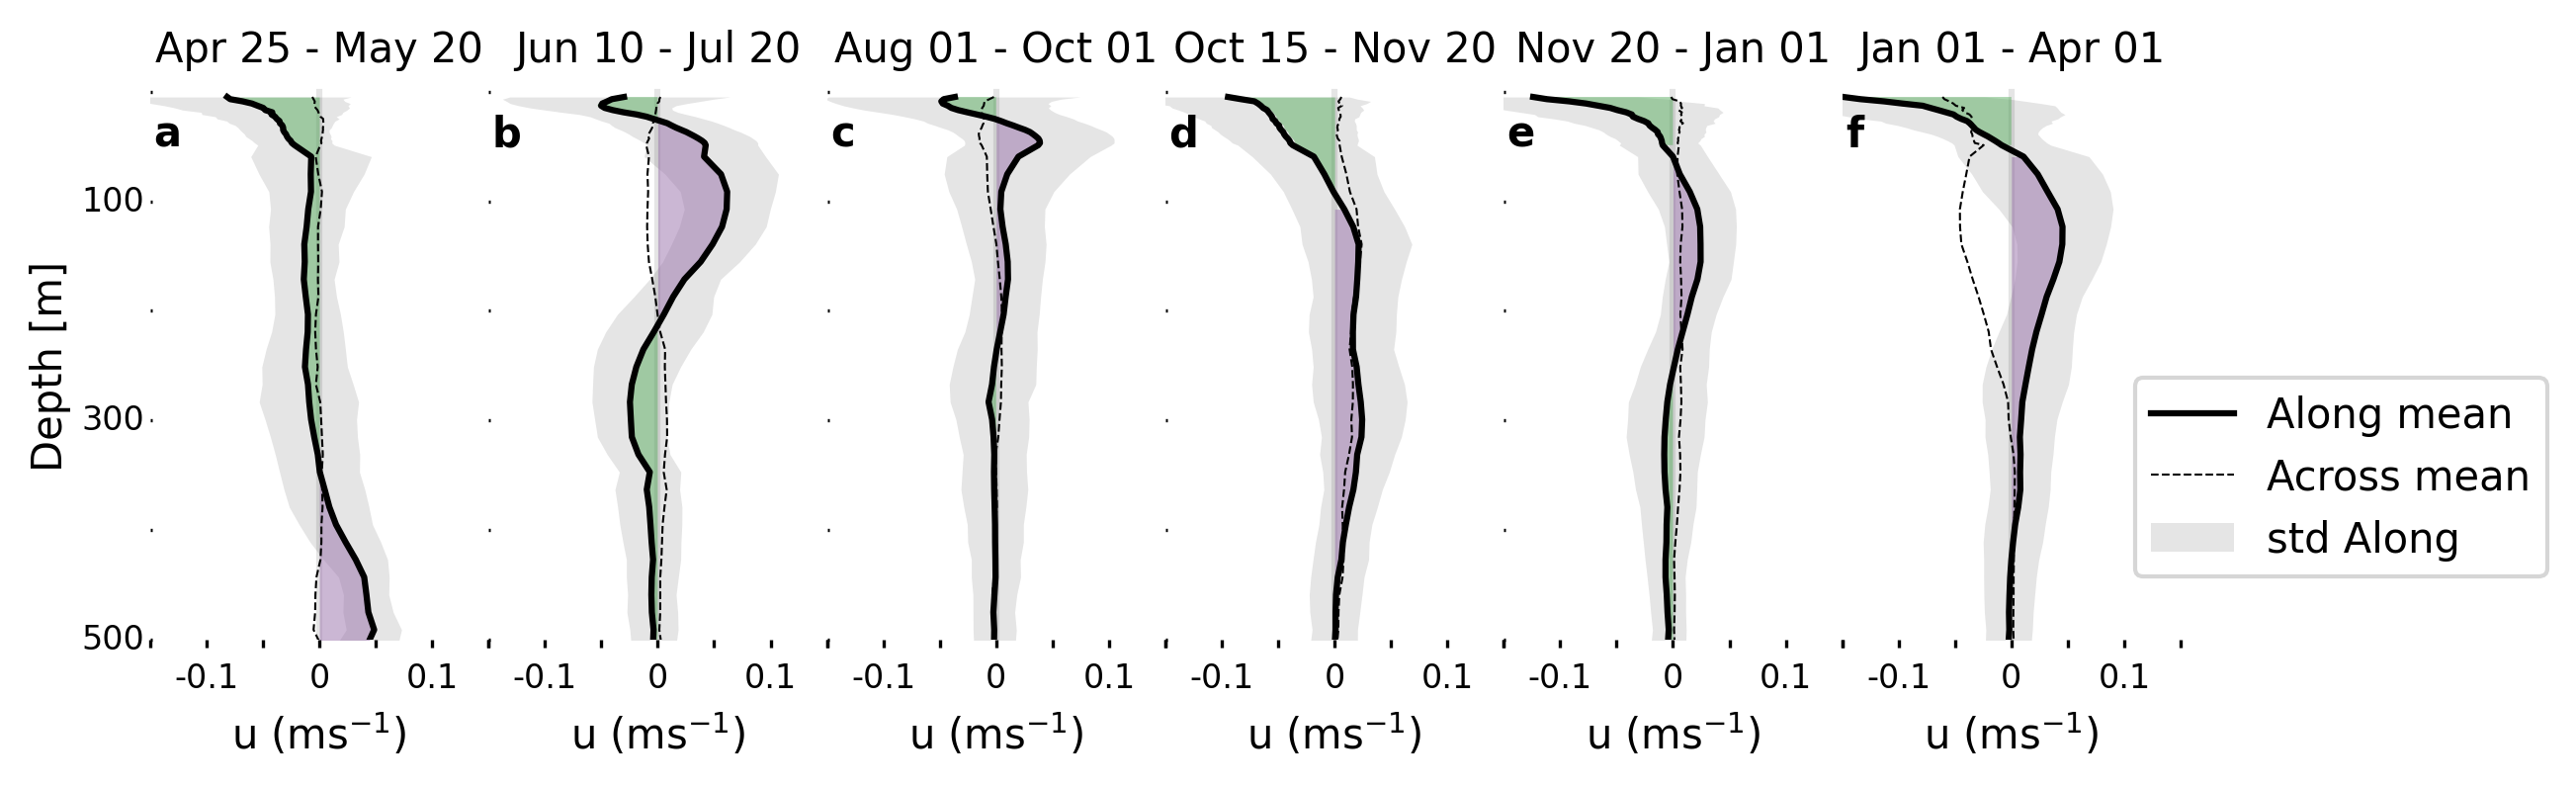

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# figsize in mm
width_mm = 190
height_mm = 70

# set fontsize 10
plt.rcParams.update({'font.size': 10})

fig = plt.figure( figsize=(width_mm/25.4, height_mm/25.4), dpi=300)

nrplots = 6

colorVpos = plt.get_cmap('PRGn_r')(0.8)
colorVneg = plt.get_cmap('PRGn')(0.8)

def velocity_profile_subplot(ax, time_start, time_end, fill_between="std"):
    line_color = 'black'
    ds_velo_select_phase = xr.merge([ds_velo_300.isel(z=slice(1,None)), ds_velo_75.isel(z=slice(None,-1))], join='outer').sel(time=slice(time_start, time_end))/1000
    ds_velo_select_phase.mean('time').Alongmmpersec.plot(ax=ax, label='Along mean', y='z', color=line_color)
    ds_velo_select_phase.mean('time').Acrossmmpersec.plot(ax=ax, label='Across mean', y='z', linestyle='--' , color = line_color, linewidth=0.5)
    if fill_between =="5-95":
        ax.fill_betweenx(ds_velo_select_phase.z, ds_velo_select_phase.quantile([0.05], dim='time').Along_res.squeeze().values,ds_velo_select_phase.quantile([0.95], dim='time').Along_res.squeeze().values,  alpha=0.1, label='5th and 95th quantile', color = line_color, linewidth=0,)
    if fill_between == 'std':
        ax.fill_betweenx(ds_velo_select_phase.z, ds_velo_select_phase.mean('time').Along_res.squeeze().values-ds_velo_select_phase.std('time').Along_res.squeeze().values, ds_velo_select_phase.mean('time').Along_res.squeeze().values+ds_velo_select_phase.std('time').Along_res.squeeze().values,  alpha=0.1, label='std Along', color = line_color, linewidth=0,)
    ax.set_title(f'{pd.to_datetime(time_start).strftime("%b %d")} - {pd.to_datetime(time_end).strftime("%b %d")}', fontsize=10)
    
    ax.fill_betweenx(ds_velo_select_phase.z, ds_velo_select_phase.mean('time').Along_res.squeeze().where(ds_velo_select_phase.mean('time').Alongmmpersec>0).values, 0,  alpha=0.5, color = colorVpos , linewidth=0)
    ax.fill_betweenx(ds_velo_select_phase.z, ds_velo_select_phase.mean('time').Along_res.squeeze().where(ds_velo_select_phase.mean('time').Alongmmpersec<0).values, 0,  alpha=0.5,  color = colorVneg , linewidth=0)   

    return ds_velo_select_phase

ax0 = fig.add_subplot(1, nrplots, 6)
ds_velo_winter_circ = velocity_profile_subplot(ax0, time_start='2019-01-01', time_end='2019-04-01')
ax0.set_xlim([-0.15,0.15])


ax0.set_ylim([500,-5])
ax0.set_yticks(np.arange(0, 550, 100), labels = np.arange(0, 550, 100))
ax0.set_label('Depth [m]')

ax=ax0
ax2 = fig.add_subplot(1, nrplots,1, sharex=ax0, sharey=ax0)
velocity_profile_subplot(ax2, time_start='2019-04-25', time_end='2019-05-20')
ax3 = fig.add_subplot(1, nrplots,2, sharex=ax0, sharey=ax0)
velocity_profile_subplot(ax3, time_start='2018-06-10', time_end='2018-07-20')
ax4 = fig.add_subplot(1, nrplots,3, sharex=ax, sharey=ax)
velocity_profile_subplot(ax4, time_start='2018-08-01', time_end='2018-10-01')
ax5 = fig.add_subplot(1, nrplots,4, sharex=ax, sharey=ax)
velocity_profile_subplot(ax5, time_start='2018-10-15', time_end='2018-11-20')
ax6 = fig.add_subplot(1, nrplots,5, sharex=ax, sharey=ax)
velocity_profile_subplot(ax6, time_start='2018-11-20', time_end='2019-01-01')

import warnings


phase_nr = ["VI", "I", "II", "III", "IV", "V"]

for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.set_xlabel(r'u (ms$^{-1}$)')
    remove_spines(ax)
    ax.plot([0,0], [0, 500], alpha=0.1, color='k',zorder=0)
    ax.tick_params(axis='y', which='major', labelsize=8, length=0.5, direction='in')
    ax.tick_params(axis='x', which='major', labelsize=8, length=2, )
    ax.set_xticks([-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15])
    ax.set_xticklabels(["", -0.1, "", 0, "", 0.1, ""])
5
#
for ztick in [100, 300, 500]:
    ax2.text(-0.155, ztick, str(ztick), rotation=0, fontsize=8, ha='right', va='center')
ax2.text(-0.22, 250, 'Depth [m]', rotation=90, fontsize=10, ha='right', va='center')
ax0.tick_params(axis='y', which='major', labelsize=8, length=0.0, direction='in')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='lower left', bbox_to_anchor=(0.95, 0.25), ncol=1)
plt.tight_layout()

# add text to subplots 
alphabet = ['f', 'a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(fig.axes):
    ax.text(0.01, 0.95, f'{alphabet[i]}', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')

fig.subplots_adjust(wspace=-0.0)
# change tick length on y axis to 1
# save figure
# transparent background
# plt.savefig(f'{figpath}/Velocity profile/velocity_along_phases_for_ppt.png', bbox_inches='tight', dpi=600, transparent=True)
# plt.savefig(f'{figpath}/Velocity profile/velocity_along_phases_draft.jpg', bbox_inches='tight', dpi=150)


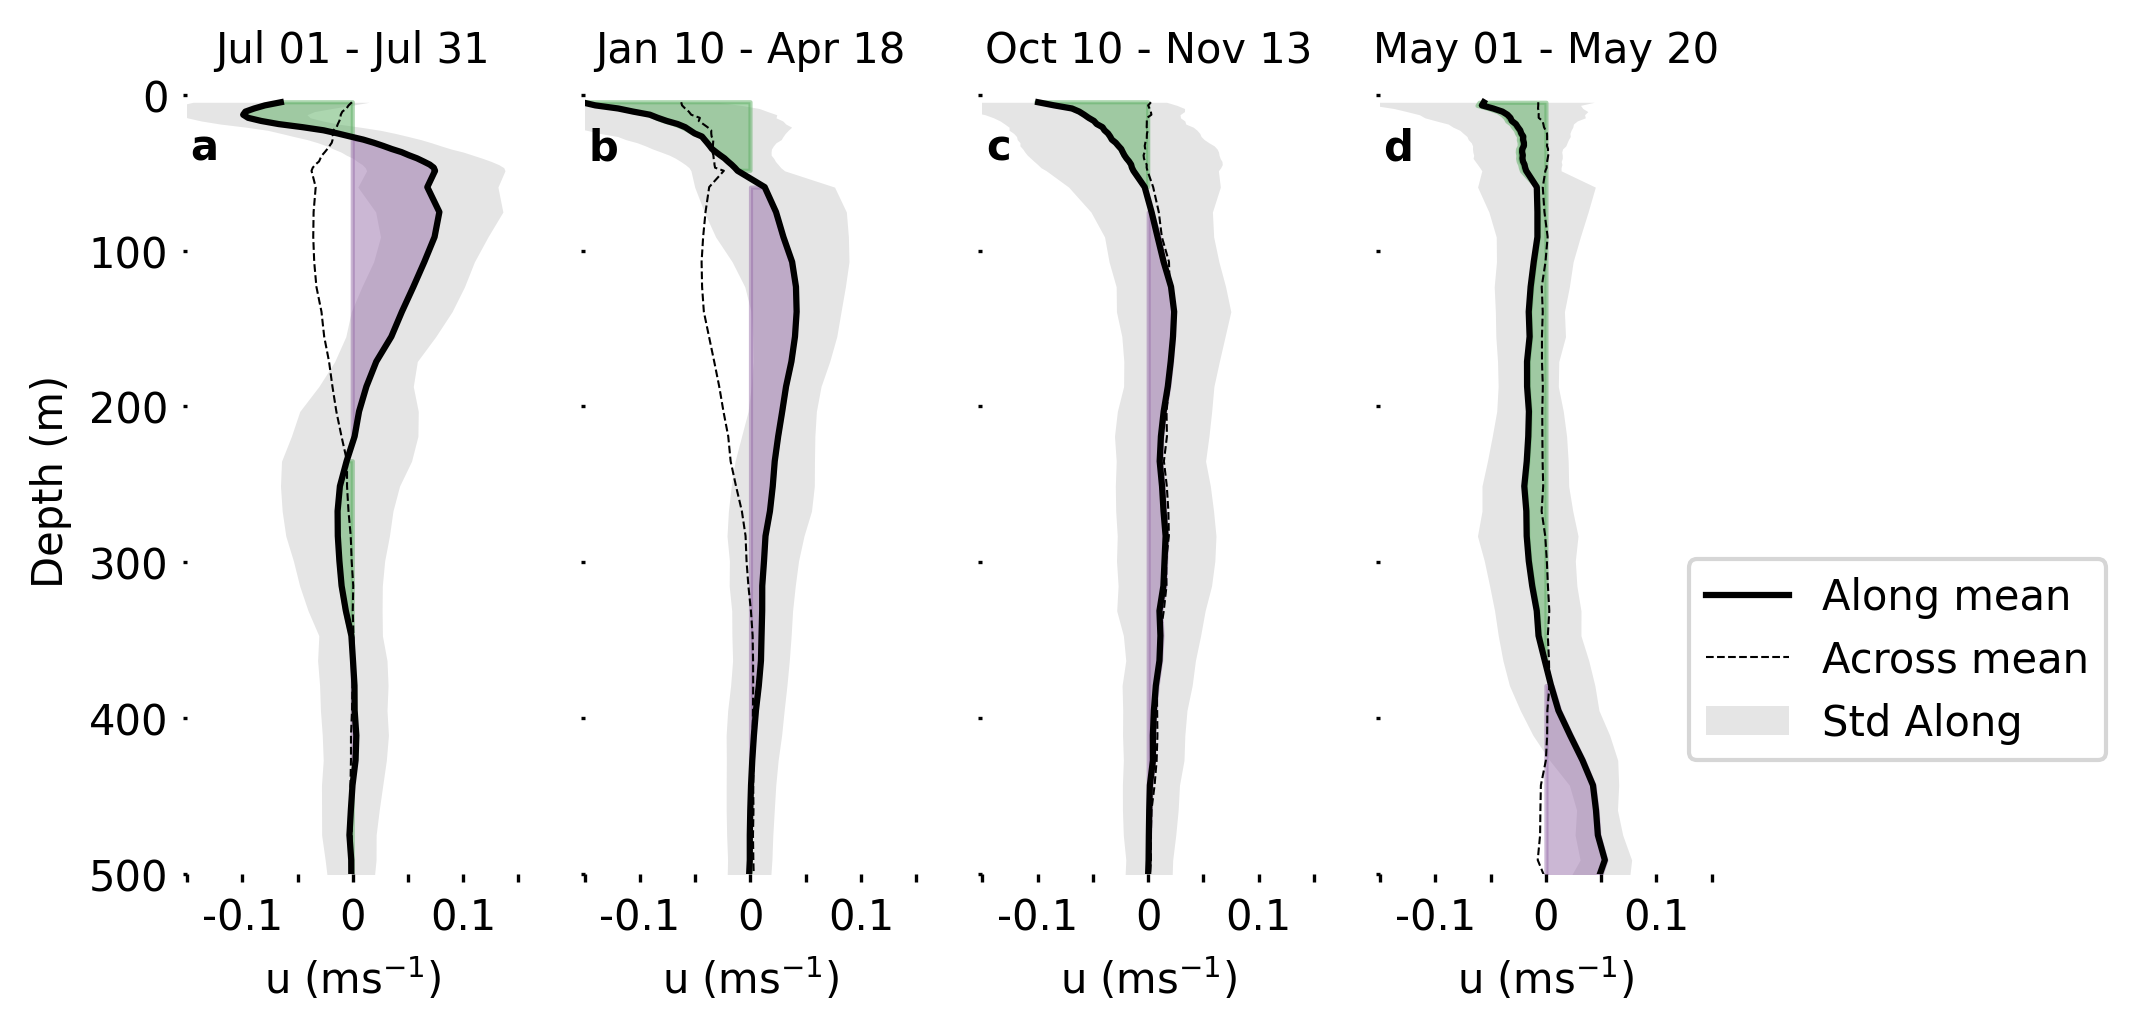

In [ ]:


# Ignore warnings
warnings.filterwarnings('ignore')

# Set plot configurations
width_mm = 150  # Adjusted for 4 subplots
height_mm = 90
nrplots = 4
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4), dpi=300)

color_positive = plt.get_cmap('PRGn_r')(0.8)
color_negative = plt.get_cmap('PRGn')(0.8)

def plot_velocity_profile(ax, time_start, time_end, fill_between="std"):
    """
    Plots velocity profile for the specified time range.
    """
    line_color = 'black'

    # Merge datasets and select time range
    ds_velo_select_phase = xr.merge([
        ds_velo_300.isel(z=slice(1, None)),
        ds_velo_75.isel(z=slice(None, -1))
    ], join='outer').sel(time=slice(time_start, time_end)) / 1000

    # Plot mean profiles
    ds_velo_select_phase.mean('time').Alongmmpersec.plot(ax=ax, label='Along mean', y='z', color=line_color)
    ds_velo_select_phase.mean('time').Acrossmmpersec.plot(ax=ax, label='Across mean', y='z', linestyle='--', color=line_color, linewidth=0.5)

    # Fill between for uncertainty
    if fill_between == "5-95":
        ax.fill_betweenx(
            ds_velo_select_phase.z,
            ds_velo_select_phase.quantile(0.05, dim='time').Along_res.squeeze().values,
            ds_velo_select_phase.quantile(0.95, dim='time').Along_res.squeeze().values,
            alpha=0.1, label='5th-95th quantile', color=line_color
        )
    elif fill_between == 'std':
        ax.fill_betweenx(
            ds_velo_select_phase.z,
            ds_velo_select_phase.mean('time').Along_res.squeeze().values - ds_velo_select_phase.std('time').Along_res.squeeze().values,
            ds_velo_select_phase.mean('time').Along_res.squeeze().values + ds_velo_select_phase.std('time').Along_res.squeeze().values,
            alpha=0.1, label='Std Along', color=line_color, linewidth=0
        )

    # Highlight positive and negative velocities
    ax.fill_betweenx(
        ds_velo_select_phase.z,
        ds_velo_select_phase.mean('time').Along_res.squeeze().where(ds_velo_select_phase.mean('time').Alongmmpersec > 0).values,
        0, alpha=0.5, color=color_positive
    )
    ax.fill_betweenx(
        ds_velo_select_phase.z,
        ds_velo_select_phase.mean('time').Along_res.squeeze().where(ds_velo_select_phase.mean('time').Alongmmpersec < 0).values,
        0, alpha=0.5, color=color_negative
    )

    ax.set_title(f'{pd.to_datetime(time_start).strftime("%b %d")} - {pd.to_datetime(time_end).strftime("%b %d")}', fontsize=10)
    return ds_velo_select_phase

# Plot subplots with updated layout
subplot_times = [
    ('2018-07-01', '2018-07-31'),
    ('2019-01-10', '2019-04-18'),
    ('2018-10-10', '2018-11-13'),
    ('2019-05-01', '2019-05-20')
]

axes = []
for i, (start_time, end_time) in enumerate(subplot_times):
    ax = fig.add_subplot(1, nrplots, i + 1)
    plot_velocity_profile(ax, time_start=start_time, time_end=end_time)
    ax.set_xlim([-0.15, 0.15])
    ax.set_xticks([-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15])
    ax.set_xticklabels(["", -0.1, "", 0, "", 0.1, ""])
    ax.tick_params(axis='x', which='major', length=2, )
    ax.set_ylim([500, -5])
    ax.set_xlabel(r'u (ms$^{-1}$)')
    if i == 0:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.tick_params(axis='y', length=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    axes.append(ax)

# Add subplot labels
alphabet = ['a', 'b', 'c', 'd']
for i, ax in enumerate(axes):
    ax.text(0.01, 0.95, f'{alphabet[i]}', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')

# Legend configuration
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='lower left', bbox_to_anchor=(0.95, 0.25), ncol=1)

plt.tight_layout()
fig.subplots_adjust(wspace=0.2)

# Save figures with transparent background
# plt.savefig(f'{figpath}/Velocity_profile/velocity_along_phases_for_ppt.png', bbox_inches='tight', dpi=600, transparent=True)
# plt.savefig(f'{figpath}/Velocity_profile/velocity_along_phases_draft.jpg', bbox_inches='tight', dpi=150)

plt.show()
